# Post-Outlier Removal Modelling

This notebook includes all non-neural network models after outlier removal via IQR.

Models included in this notebook:
- Linear Regression
- Random Forest Regressor

In [1]:
# Fundamentals
import numpy as np
import seaborn as sns
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

**Load in Data**

In [2]:
# Load in all datasets before outlier removal
X_train = pd.read_csv('data/outlier_clean_X_train.csv')
y_train = pd.read_csv('data/outlier_clean_y_train.csv')
X_test = pd.read_csv('data/outlier_clean_X_test.csv')
y_test = pd.read_csv('data/outlier_clean_y_test.csv')

### Machine Learning Models

#### Cross Validation

##### Random Forest Regressor

In [217]:
# Find the cross validation scores to find optimal max_depth
# Create list for cross val scores and max_depths
RFR_cross_val_scores = []
max_depths = range(1, 51)

# Use for loop on pipeline to get cross val scores
for depth in max_depths:
    RFR_estimators = [('normalise', MinMaxScaler()),
                  ('reduce_dim', PCA(n_components=5)),
                  ('RFR', RandomForestRegressor(max_depth=depth, random_state=1))]
    RFR_pipe = Pipeline(RFR_estimators)
    
    # Get average cross validation score for each depth and append to the list of scores
    cv_score = cross_val_score(RFR_pipe, X_train, y_train, cv=5, n_jobs=-1)
    mean_cv_score = np.mean(cv_score)
    
    RFR_cross_val_scores.append(mean_cv_score)
    
    print(depth, end='\r')

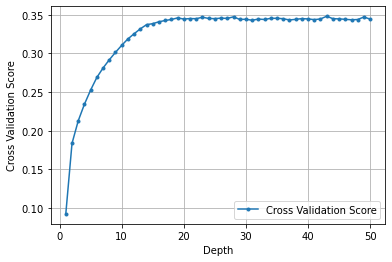

In [218]:
# Take a look at the cross validation scores
plt.figure()
plt.plot(max_depths, RFR_cross_val_scores, label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

In [220]:
# Get R2 score based on findings above
RFR_estimators2 = [('normalise', MinMaxScaler()),
                  ('reduce_dim', PCA(n_components=5)),
                  ('RFR', RandomForestRegressor(max_depth=19,
                                                random_state=1))]

RFR_pipe2 = Pipeline(RFR_estimators2)
RFR_pipe2.fit(X_train, y_train)
RFR_pipe2.score(X_test, y_test)

0.37672101941261726

Compared to the pre-outlier removal which indicated that a `max_depth` of 30 was the best parameter (potentially due to a change in the `n_components` from 120 to 5), I can see that for this cross-validation the best `max_depth` value is at 19 where the curve plateaus following any `max_depth` values afterwards. 

However, this value was not nearly as good as the linear regression model or the neural network model. Thus, I did not continue optimizing the `n_estimators` parameter as the value would not increase the value.

#### PCA

PCA is used here to show the effect of a non-reduced dataset and reduced dataset using `LinearRegression` in my modelling.

In [210]:
# Scale the data
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(X_train)

# Transform the X_train data
scaled_X_train = minmaxscaler.transform(X_train)
scaled_X_test = minmaxscaler.transform(X_test)

In [211]:
# Fit a PCA model with train data
pca = PCA(n_components=200)
pca.fit(scaled_X_train)

pca_X_train = pca.transform(scaled_X_train)
pca_X_test = pca.transform(scaled_X_test)

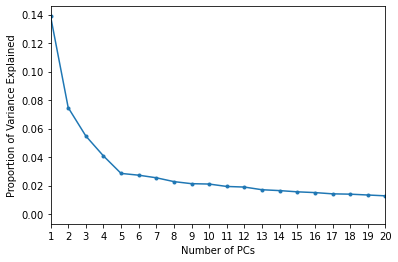

In [212]:
# Get the explained variance ratio and plot the data points
pca_expl_var_ratio = pca.explained_variance_ratio_
plt.figure()
plt.plot(range(1,201), pca_expl_var_ratio, marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,201,1))
plt.xlim(1, 20)
plt.show()

The PCA value of 5 remains the same as the modelling notebook that has included outliers in the data. 

#### Linear Regression

My assumption remains the same that a `LinearRegression` model before PCA will be very poor, but the PCA-reduced dataset should have significantly better results.

In [213]:
# Fit linear regression model
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(scaled_X_train, y_train)

# Score on the train and test data
print(f'Score on the train set: {linear_reg.score(scaled_X_train, y_train)}')
print(f'Score on the test set: {linear_reg.score(scaled_X_test, y_test)}')

Score on the train set: 0.5729665122134612
Score on the test set: -6.094097463074755e+17


I can see that the model has performed extremely poorly as expected. Let's use the PCA transformed data and see if that changes the results.

In [214]:
# Fit linear regression model
pca_linear_reg = LinearRegression(n_jobs=-1)
pca_linear_reg.fit(pca_X_train, y_train)

# Score on the train and test data
print(f'Score on the train set: {pca_linear_reg.score(pca_X_train, y_train)}')
print(f'Score on the test set: {pca_linear_reg.score(pca_X_test, y_test)}')

Score on the train set: 0.5672716111434315
Score on the test set: 0.5668593430773767


This is a significantly better $R^2$ score as compared to all other modelling attempts. Although the neural network model returned the best results compared to all of the models in this notebook, these results show that the a portion of the relationships between my features and `price` can be explained using a simple linear regression model.